In [1]:

import os
import pandas as pd

# CSVの読み込み
df = pd.read_csv("C:/Users/yuba1/Downloads/archive/Data_Entry_2017.csv")

# ラベル付け: 'Mass' を含むかどうかで癌判定
df["Cancer"] = df["Finding Labels"].apply(lambda x: 1 if "Mass" in x else 0)


In [2]:

from sklearn.utils import shuffle

# 陽性データと陰性データをバランスさせる
df_1 = df[df["Cancer"] == 1]
df_0 = df[df["Cancer"] == 0].sample(n=len(df_1), random_state=42)
df_balanced = pd.concat([df_1, df_0])
df_balanced = shuffle(df_balanced, random_state=42)

# 実際に存在する画像の行だけを抽出
valid_rows = []
for idx, row in df_balanced.iterrows():
    filename = row["Image Index"]
    for i in range(1, 13):
        image_path = f"archive/images_{i:03d}/images/{filename}"
        if os.path.exists(image_path):
            valid_rows.append({"filename": image_path, "class": row["Cancer"]})
            break

df_paths = pd.DataFrame(valid_rows)
df_paths["class"] = df_paths["class"].astype(str)


C:\Users\yuba1\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# データ分割
train_df, test_df = train_test_split(df_paths, test_size=0.2, stratify=df_paths["class"], random_state=42)

# データ拡張ジェネレータ
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

# 画像サイズを128x128に縮小
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 9251 validated image filenames belonging to 2 classes.
Found 2313 validated image filenames belonging to 2 classes.


In [4]:

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np

# 転移学習ベース
base_model = DenseNet121(include_top=False, input_shape=(128, 128, 3), pooling='avg', weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# モデル定義
model = models.Sequential([
    base_model,
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC', 'Recall'])

# クラス重みの計算
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['class']),
    y=train_df['class']
)
class_weights_dict = dict(enumerate(class_weights))

# コールバック
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]


In [5]:

# 学習実行
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=callbacks
)


C:\Users\yuba1\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 240s 802ms/step - AUC: 0.5733 - Recall: 0.5763 - accuracy: 0.5521 - loss: 0.7284 - val_AUC: 0.6389 - val_Recall: 0.5761 - val_accuracy: 0.5949 - val_loss: 0.6902 - learning_rate: 1.0000e-04
Epoch 2/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 242s 834ms/step - AUC: 0.6555 - Recall: 0.5763 - accuracy: 0.6087 - loss: 0.6632 - val_AUC: 0.6687 - val_Recall: 0.5536 - val_accuracy: 0.6230 - val_loss: 0.6687 - learning_rate: 1.0000e-04
Epoch 3/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 246s 848ms/step - AUC: 0.6830 - Recall: 0.6317 - accuracy: 0.6367 - loss: 0.6459 - val_AUC: 0.6838 - val_Recall: 0.5476 - val_accuracy: 0.6334 - val_loss: 0.6563 - learning_rate: 1.0000e-04
Epoch 4/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 242s 833ms/step - AUC: 0.6930 - Recall: 0.6277 - accuracy: 0.6371 - loss: 0.6378 - val_AUC: 0.6847 - val_Recall: 0.5087 - val_accuracy: 0.6316 - val_loss: 0.6632 - learning_rate: 1.0000e-04
Epoch 5/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 239s 824ms/step - AUC: 0.7054 - Recall: 

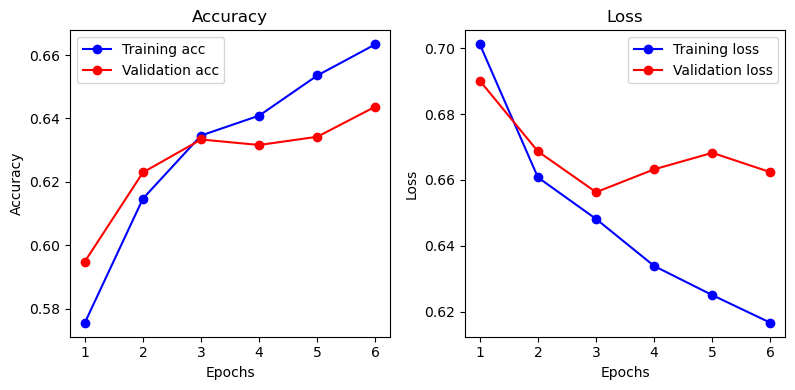

In [6]:
import matplotlib.pyplot as plt

# history から値を取得
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
auc = history.history.get('auc', [])
val_auc = history.history.get('val_auc', [])
recall = history.history.get('recall', [])
val_recall = history.history.get('val_recall', [])

epochs = range(1, len(acc) + 1)

# 精度の可視化
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 損失の可視化
plt.subplot(1, 3, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# AUCの可視化（あれば）
if auc:
    plt.subplot(1, 3, 3)
    plt.plot(epochs, auc, 'bo-', label='Training AUC')
    plt.plot(epochs, val_auc, 'ro-', label='Validation AUC')
    plt.title('AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

plt.tight_layout()
plt.show()

# Recallも表示（オプション）
if recall:
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, recall, 'bo-', label='Training Recall')
    plt.plot(epochs, val_recall, 'ro-', label='Validation Recall')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid()
    plt.show()

In [7]:
model.save("C:/Users/yuba1/Downloads/recall_balanced_model.h5")
print("モデルを recall_balanced_model.h5 として保存しました。")

モデルを recall_balanced_model.h5 として保存しました。


In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import roc_curve

# モデル読み込み（事前に .h5 ファイルを同ディレクトリにアップしておく）
model = load_model("C:/Users/yuba1/Downloads/recall_balanced_model.h5")
print("モデルを読み込みました。")

モデルを読み込みました。


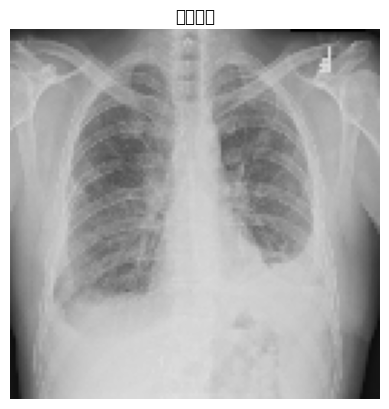

In [32]:

# 推論対象画像のパス
image_path = "C:/Users/yuba1/Downloads/mass_sample_images/mass_402.png"  # ← 推論したい画像のパスをここに記載

# 画像読み込み・リサイズ・正規化
img = image.load_img(image_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)  # (1, 128, 128, 3)

# 表示
plt.imshow(img_array[0])
plt.title("対象画像")
plt.axis("off")
plt.show()

In [33]:

# 推論実行
prob = model.predict(img_array)[0][0]
print(f"陽性である確率: {prob:.4f}")

# 閾値0.5で判定
threshold = 0.5
prediction = 1 if prob > threshold else 0
label = "陽性 (癌)" if prediction == 1 else "陰性 (非癌)"
print(f"分類結果: {label}（閾値={threshold}）")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
陽性である確率: 0.7089
分類結果: 陽性 (癌)（閾値=0.5）


In [15]:

# （学習・検証済みデータから）予測スコアと正解ラベルを取得しておく
# ここでは例として test_generator を使用する想定です

y_true = test_generator.classes
y_score = model.predict(test_generator).ravel()

# ROC曲線から最適な閾値を計算（Youden's J統計量）
fpr, tpr, thresholds = roc_curve(y_true, y_score)
j_scores = tpr - fpr
best_thresh = thresholds[np.argmax(j_scores)]

print(f"最適な閾値（Youden's J）: {best_thresh:.4f}")

73/73 ━━━━━━━━━━━━━━━━━━━━ 36s 498ms/step
最適な閾値（Youden's J）: 0.5112


In [16]:
# 最適閾値で再分類
prediction = 1 if prob > best_thresh else 0
label = "陽性 (癌)" if prediction == 1 else "陰性 (非癌)"
print(f"最適閾値 {best_thresh:.4f} による再分類: {label}")

最適閾値 0.5112 による再分類: 陰性 (非癌)


In [19]:
import pandas as pd
import os
import shutil

# CSV読み込み
df = pd.read_csv("C:/Users/yuba1/Downloads/archive/Data_Entry_2017.csv")

# 'Mass' を含む陽性画像だけを抽出
mass_df = df[df["Finding Labels"].str.contains("Mass", case=False)]

# 保存ディレクトリ作成
output_dir = "C:/Users/yuba1/Downloads/mass_sample_images"
os.makedirs(output_dir, exist_ok=True)

# 最初の3枚を images/ フォルダからコピー
count = 0
for i, row in mass_df.iterrows():
    filename = row["Image Index"]
    for i in range(1, 13):
        src_path = f"archive/images_{i:03d}/images/{filename}"
        dst_path = os.path.join(output_dir, f"mass_{count+1}.png")
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
            print(f"✔ Copied: {filename} → {dst_path}")
            count += 1
        if count == 3:
            break

for idx, row in df_balanced.iterrows():
    filename = row["Image Index"]
    for i in range(1, 13):
        image_path = f"archive/images_{i:03d}/images/{filename}"
        if os.path.exists(image_path):
            valid_rows.append({"filename": image_path, "class": row["Cancer"]})
            break        
        
        
if count < 3:
    print("⚠ 指定の条件に一致する画像が3枚見つかりませんでした。")

✔ Copied: 00000004_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1.png
✔ Copied: 00000012_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2.png
✔ Copied: 00000013_022.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3.png
✔ Copied: 00000013_023.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4.png
✔ Copied: 00000013_024.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5.png
✔ Copied: 00000013_025.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_6.png
✔ Copied: 00000013_027.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_7.png
✔ Copied: 00000013_028.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_8.png
✔ Copied: 00000013_029.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_9.png
✔ Copied: 00000013_030.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_10.png
✔ Copied: 00000013_031.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_11.png
✔ Copied: 00000013_032.png → C:/Users/yuba1/Downloads/mass_sample_images\m

✔ Copied: 00001534_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_192.png
✔ Copied: 00001580_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_193.png
✔ Copied: 00001582_017.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_194.png
✔ Copied: 00001583_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_195.png
✔ Copied: 00001605_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_196.png
✔ Copied: 00001615_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_197.png
✔ Copied: 00001637_006.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_198.png
✔ Copied: 00001637_007.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_199.png
✔ Copied: 00001637_008.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_200.png
✔ Copied: 00001637_009.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_201.png
✔ Copied: 00001637_010.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_202.png
✔ Copied: 00001643_001.png → C:/Users/yuba1/Downloads/

✔ Copied: 00002955_010.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_364.png
✔ Copied: 00002983_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_365.png
✔ Copied: 00003006_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_366.png
✔ Copied: 00003006_004.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_367.png
✔ Copied: 00003006_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_368.png
✔ Copied: 00003045_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_369.png
✔ Copied: 00003065_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_370.png
✔ Copied: 00003086_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_371.png
✔ Copied: 00003089_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_372.png
✔ Copied: 00003100_006.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_373.png
✔ Copied: 00003101_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_374.png
✔ Copied: 00003121_000.png → C:/Users/yuba1/Downloads/

✔ Copied: 00004439_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_520.png
✔ Copied: 00004439_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_521.png
✔ Copied: 00004447_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_522.png
✔ Copied: 00004460_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_523.png
✔ Copied: 00004465_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_524.png
✔ Copied: 00004471_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_525.png
✔ Copied: 00004504_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_526.png
✔ Copied: 00004504_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_527.png
✔ Copied: 00004519_007.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_528.png
✔ Copied: 00004519_014.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_529.png
✔ Copied: 00004519_015.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_530.png
✔ Copied: 00004523_000.png → C:/Users/yuba1/Downloads/

✔ Copied: 00005348_010.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_647.png
✔ Copied: 00005348_011.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_648.png
✔ Copied: 00005348_012.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_649.png
✔ Copied: 00005348_013.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_650.png
✔ Copied: 00005348_015.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_651.png
✔ Copied: 00005380_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_652.png
✔ Copied: 00005388_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_653.png
✔ Copied: 00005388_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_654.png
✔ Copied: 00005395_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_655.png
✔ Copied: 00005410_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_656.png
✔ Copied: 00005410_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_657.png
✔ Copied: 00005410_004.png → C:/Users/yuba1/Downloads/

✔ Copied: 00006273_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_795.png
✔ Copied: 00006273_004.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_796.png
✔ Copied: 00006273_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_797.png
✔ Copied: 00006273_006.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_798.png
✔ Copied: 00006273_007.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_799.png
✔ Copied: 00006273_008.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_800.png
✔ Copied: 00006275_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_801.png
✔ Copied: 00006302_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_802.png
✔ Copied: 00006304_012.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_803.png
✔ Copied: 00006308_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_804.png
✔ Copied: 00006308_004.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_805.png
✔ Copied: 00006308_005.png → C:/Users/yuba1/Downloads/

✔ Copied: 00007227_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_965.png
✔ Copied: 00007230_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_966.png
✔ Copied: 00007264_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_967.png
✔ Copied: 00007296_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_968.png
✔ Copied: 00007322_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_969.png
✔ Copied: 00007322_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_970.png
✔ Copied: 00007322_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_971.png
✔ Copied: 00007322_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_972.png
✔ Copied: 00007322_004.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_973.png
✔ Copied: 00007354_009.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_974.png
✔ Copied: 00007354_011.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_975.png
✔ Copied: 00007354_012.png → C:/Users/yuba1/Downloads/

✔ Copied: 00008051_029.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1137.png
✔ Copied: 00008064_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1138.png
✔ Copied: 00008081_004.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1139.png
✔ Copied: 00008081_006.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1140.png
✔ Copied: 00008081_016.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1141.png
✔ Copied: 00008081_017.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1142.png
✔ Copied: 00008087_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1143.png
✔ Copied: 00008100_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1144.png
✔ Copied: 00008100_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1145.png
✔ Copied: 00008147_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1146.png
✔ Copied: 00008154_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1147.png
✔ Copied: 00008185_008.png → C:/Users/yuba1

✔ Copied: 00008777_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1259.png
✔ Copied: 00008777_006.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1260.png
✔ Copied: 00008807_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1261.png
✔ Copied: 00008807_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1262.png
✔ Copied: 00008811_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1263.png
✔ Copied: 00008822_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1264.png
✔ Copied: 00008823_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1265.png
✔ Copied: 00008829_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1266.png
✔ Copied: 00008841_009.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1267.png
✔ Copied: 00008841_032.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1268.png
✔ Copied: 00008841_047.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1269.png
✔ Copied: 00008841_048.png → C:/Users/yuba1

✔ Copied: 00009523_008.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1404.png
✔ Copied: 00009555_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1405.png
✔ Copied: 00009580_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1406.png
✔ Copied: 00009584_008.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1407.png
✔ Copied: 00009587_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1408.png
✔ Copied: 00009587_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1409.png
✔ Copied: 00009592_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1410.png
✔ Copied: 00009592_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1411.png
✔ Copied: 00009592_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1412.png
✔ Copied: 00009592_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1413.png
✔ Copied: 00009604_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1414.png
✔ Copied: 00009604_001.png → C:/Users/yuba1

✔ Copied: 00009967_004.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1513.png
✔ Copied: 00009969_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1514.png
✔ Copied: 00009972_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1515.png
✔ Copied: 00009979_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1516.png
✔ Copied: 00009979_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1517.png
✔ Copied: 00009984_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1518.png
✔ Copied: 00009984_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1519.png
✔ Copied: 00009984_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1520.png
✔ Copied: 00009984_004.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1521.png
✔ Copied: 00009984_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1522.png
✔ Copied: 00009984_008.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1523.png
✔ Copied: 00009993_001.png → C:/Users/yuba1

✔ Copied: 00010584_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1651.png
✔ Copied: 00010584_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1652.png
✔ Copied: 00010584_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1653.png
✔ Copied: 00010584_006.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1654.png
✔ Copied: 00010585_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1655.png
✔ Copied: 00010592_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1656.png
✔ Copied: 00010604_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1657.png
✔ Copied: 00010608_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1658.png
✔ Copied: 00010608_006.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1659.png
✔ Copied: 00010608_008.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1660.png
✔ Copied: 00010610_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1661.png
✔ Copied: 00010610_006.png → C:/Users/yuba1

✔ Copied: 00011355_027.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1797.png
✔ Copied: 00011355_029.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1798.png
✔ Copied: 00011355_030.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1799.png
✔ Copied: 00011355_032.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1800.png
✔ Copied: 00011355_036.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1801.png
✔ Copied: 00011355_037.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1802.png
✔ Copied: 00011355_039.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1803.png
✔ Copied: 00011355_040.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1804.png
✔ Copied: 00011355_041.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1805.png
✔ Copied: 00011355_042.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1806.png
✔ Copied: 00011355_045.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1807.png
✔ Copied: 00011355_046.png → C:/Users/yuba1

✔ Copied: 00011831_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1934.png
✔ Copied: 00011831_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1935.png
✔ Copied: 00011831_015.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1936.png
✔ Copied: 00011831_025.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1937.png
✔ Copied: 00011834_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1938.png
✔ Copied: 00011835_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1939.png
✔ Copied: 00011845_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1940.png
✔ Copied: 00011845_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1941.png
✔ Copied: 00011845_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1942.png
✔ Copied: 00011845_014.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1943.png
✔ Copied: 00011845_017.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_1944.png
✔ Copied: 00011859_001.png → C:/Users/yuba1

✔ Copied: 00012242_004.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2042.png
✔ Copied: 00012242_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2043.png
✔ Copied: 00012244_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2044.png
✔ Copied: 00012263_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2045.png
✔ Copied: 00012263_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2046.png
✔ Copied: 00012263_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2047.png
✔ Copied: 00012263_006.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2048.png
✔ Copied: 00012263_007.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2049.png
✔ Copied: 00012270_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2050.png
✔ Copied: 00012270_004.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2051.png
✔ Copied: 00012270_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2052.png
✔ Copied: 00012283_000.png → C:/Users/yuba1

✔ Copied: 00012892_009.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2190.png
✔ Copied: 00012892_010.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2191.png
✔ Copied: 00012892_012.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2192.png
✔ Copied: 00012922_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2193.png
✔ Copied: 00012922_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2194.png
✔ Copied: 00012924_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2195.png
✔ Copied: 00012927_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2196.png
✔ Copied: 00012927_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2197.png
✔ Copied: 00012927_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2198.png
✔ Copied: 00012927_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2199.png
✔ Copied: 00012927_004.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2200.png
✔ Copied: 00012927_005.png → C:/Users/yuba1

✔ Copied: 00013637_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2354.png
✔ Copied: 00013648_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2355.png
✔ Copied: 00013648_010.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2356.png
✔ Copied: 00013648_017.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2357.png
✔ Copied: 00013648_019.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2358.png
✔ Copied: 00013648_022.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2359.png
✔ Copied: 00013648_023.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2360.png
✔ Copied: 00013648_026.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2361.png
✔ Copied: 00013648_028.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2362.png
✔ Copied: 00013648_029.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2363.png
✔ Copied: 00013648_030.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2364.png
✔ Copied: 00013648_031.png → C:/Users/yuba1

✔ Copied: 00014032_007.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2508.png
✔ Copied: 00014032_010.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2509.png
✔ Copied: 00014053_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2510.png
✔ Copied: 00014061_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2511.png
✔ Copied: 00014070_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2512.png
✔ Copied: 00014089_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2513.png
✔ Copied: 00014089_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2514.png
✔ Copied: 00014089_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2515.png
✔ Copied: 00014105_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2516.png
✔ Copied: 00014105_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2517.png
✔ Copied: 00014116_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2518.png
✔ Copied: 00014125_015.png → C:/Users/yuba1

✔ Copied: 00014548_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2653.png
✔ Copied: 00014551_010.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2654.png
✔ Copied: 00014570_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2655.png
✔ Copied: 00014578_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2656.png
✔ Copied: 00014581_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2657.png
✔ Copied: 00014581_004.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2658.png
✔ Copied: 00014583_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2659.png
✔ Copied: 00014583_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2660.png
✔ Copied: 00014584_004.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2661.png
✔ Copied: 00014586_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2662.png
✔ Copied: 00014588_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2663.png
✔ Copied: 00014593_001.png → C:/Users/yuba1

✔ Copied: 00014839_020.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2803.png
✔ Copied: 00014851_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2804.png
✔ Copied: 00014870_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2805.png
✔ Copied: 00014870_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2806.png
✔ Copied: 00014870_004.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2807.png
✔ Copied: 00014871_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2808.png
✔ Copied: 00014871_007.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2809.png
✔ Copied: 00014871_008.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2810.png
✔ Copied: 00014871_009.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2811.png
✔ Copied: 00014871_011.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2812.png
✔ Copied: 00014874_006.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2813.png
✔ Copied: 00014888_011.png → C:/Users/yuba1

✔ Copied: 00015495_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2963.png
✔ Copied: 00015495_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2964.png
✔ Copied: 00015495_004.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2965.png
✔ Copied: 00015495_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2966.png
✔ Copied: 00015495_006.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2967.png
✔ Copied: 00015495_008.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2968.png
✔ Copied: 00015495_014.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2969.png
✔ Copied: 00015495_015.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2970.png
✔ Copied: 00015523_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2971.png
✔ Copied: 00015524_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2972.png
✔ Copied: 00015524_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_2973.png
✔ Copied: 00015535_000.png → C:/Users/yuba1

✔ Copied: 00016051_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3105.png
✔ Copied: 00016051_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3106.png
✔ Copied: 00016051_011.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3107.png
✔ Copied: 00016051_012.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3108.png
✔ Copied: 00016060_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3109.png
✔ Copied: 00016060_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3110.png
✔ Copied: 00016064_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3111.png
✔ Copied: 00016064_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3112.png
✔ Copied: 00016064_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3113.png
✔ Copied: 00016064_009.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3114.png
✔ Copied: 00016064_010.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3115.png
✔ Copied: 00016064_012.png → C:/Users/yuba1

✔ Copied: 00016587_053.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3269.png
✔ Copied: 00016587_054.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3270.png
✔ Copied: 00016587_055.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3271.png
✔ Copied: 00016587_056.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3272.png
✔ Copied: 00016587_057.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3273.png
✔ Copied: 00016587_063.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3274.png
✔ Copied: 00016587_069.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3275.png
✔ Copied: 00016587_070.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3276.png
✔ Copied: 00016588_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3277.png
✔ Copied: 00016588_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3278.png
✔ Copied: 00016607_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3279.png
✔ Copied: 00016607_025.png → C:/Users/yuba1

✔ Copied: 00017064_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3447.png
✔ Copied: 00017064_008.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3448.png
✔ Copied: 00017064_009.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3449.png
✔ Copied: 00017064_010.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3450.png
✔ Copied: 00017064_011.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3451.png
✔ Copied: 00017064_012.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3452.png
✔ Copied: 00017064_013.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3453.png
✔ Copied: 00017064_014.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3454.png
✔ Copied: 00017064_018.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3455.png
✔ Copied: 00017068_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3456.png
✔ Copied: 00017078_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3457.png
✔ Copied: 00017089_000.png → C:/Users/yuba1

✔ Copied: 00017557_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3614.png
✔ Copied: 00017557_004.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3615.png
✔ Copied: 00017569_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3616.png
✔ Copied: 00017575_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3617.png
✔ Copied: 00017576_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3618.png
✔ Copied: 00017587_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3619.png
✔ Copied: 00017587_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3620.png
✔ Copied: 00017587_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3621.png
✔ Copied: 00017587_004.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3622.png
✔ Copied: 00017587_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3623.png
✔ Copied: 00017599_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3624.png
✔ Copied: 00017599_006.png → C:/Users/yuba1

✔ Copied: 00018091_023.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3782.png
✔ Copied: 00018091_027.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3783.png
✔ Copied: 00018091_028.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3784.png
✔ Copied: 00018101_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3785.png
✔ Copied: 00018101_006.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3786.png
✔ Copied: 00018101_007.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3787.png
✔ Copied: 00018101_009.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3788.png
✔ Copied: 00018101_010.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3789.png
✔ Copied: 00018101_012.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3790.png
✔ Copied: 00018101_013.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3791.png
✔ Copied: 00018101_014.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3792.png
✔ Copied: 00018102_004.png → C:/Users/yuba1

✔ Copied: 00018724_031.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3947.png
✔ Copied: 00018724_032.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3948.png
✔ Copied: 00018724_033.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3949.png
✔ Copied: 00018724_041.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3950.png
✔ Copied: 00018725_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3951.png
✔ Copied: 00018731_004.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3952.png
✔ Copied: 00018733_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3953.png
✔ Copied: 00018733_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3954.png
✔ Copied: 00018744_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3955.png
✔ Copied: 00018745_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3956.png
✔ Copied: 00018748_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_3957.png
✔ Copied: 00018748_004.png → C:/Users/yuba1

✔ Copied: 00019233_008.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4087.png
✔ Copied: 00019238_009.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4088.png
✔ Copied: 00019240_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4089.png
✔ Copied: 00019240_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4090.png
✔ Copied: 00019251_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4091.png
✔ Copied: 00019251_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4092.png
✔ Copied: 00019258_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4093.png
✔ Copied: 00019258_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4094.png
✔ Copied: 00019271_014.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4095.png
✔ Copied: 00019277_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4096.png
✔ Copied: 00019277_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4097.png
✔ Copied: 00019287_000.png → C:/Users/yuba1

✔ Copied: 00019767_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4245.png
✔ Copied: 00019767_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4246.png
✔ Copied: 00019767_006.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4247.png
✔ Copied: 00019767_007.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4248.png
✔ Copied: 00019767_016.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4249.png
✔ Copied: 00019769_012.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4250.png
✔ Copied: 00019769_013.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4251.png
✔ Copied: 00019773_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4252.png
✔ Copied: 00019773_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4253.png
✔ Copied: 00019773_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4254.png
✔ Copied: 00019773_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4255.png
✔ Copied: 00019774_002.png → C:/Users/yuba1

✔ Copied: 00020160_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4348.png
✔ Copied: 00020175_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4349.png
✔ Copied: 00020184_018.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4350.png
✔ Copied: 00020195_006.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4351.png
✔ Copied: 00020195_016.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4352.png
✔ Copied: 00020195_018.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4353.png
✔ Copied: 00020195_020.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4354.png
✔ Copied: 00020195_021.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4355.png
✔ Copied: 00020195_025.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4356.png
✔ Copied: 00020195_026.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4357.png
✔ Copied: 00020195_027.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4358.png
✔ Copied: 00020197_000.png → C:/Users/yuba1

✔ Copied: 00020455_006.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4448.png
✔ Copied: 00020459_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4449.png
✔ Copied: 00020469_007.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4450.png
✔ Copied: 00020469_008.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4451.png
✔ Copied: 00020477_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4452.png
✔ Copied: 00020499_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4453.png
✔ Copied: 00020499_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4454.png
✔ Copied: 00020499_006.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4455.png
✔ Copied: 00020499_007.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4456.png
✔ Copied: 00020499_011.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4457.png
✔ Copied: 00020517_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4458.png
✔ Copied: 00020562_000.png → C:/Users/yuba1

✔ Copied: 00021188_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4559.png
✔ Copied: 00021201_010.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4560.png
✔ Copied: 00021201_013.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4561.png
✔ Copied: 00021201_018.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4562.png
✔ Copied: 00021222_010.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4563.png
✔ Copied: 00021222_013.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4564.png
✔ Copied: 00021222_014.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4565.png
✔ Copied: 00021222_021.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4566.png
✔ Copied: 00021252_009.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4567.png
✔ Copied: 00021254_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4568.png
✔ Copied: 00021264_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4569.png
✔ Copied: 00021264_001.png → C:/Users/yuba1

✔ Copied: 00021840_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4693.png
✔ Copied: 00021840_025.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4694.png
✔ Copied: 00021887_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4695.png
✔ Copied: 00021889_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4696.png
✔ Copied: 00021889_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4697.png
✔ Copied: 00021894_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4698.png
✔ Copied: 00021901_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4699.png
✔ Copied: 00021911_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4700.png
✔ Copied: 00021922_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4701.png
✔ Copied: 00021942_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4702.png
✔ Copied: 00021972_013.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4703.png
✔ Copied: 00021976_002.png → C:/Users/yuba1

✔ Copied: 00022837_016.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4833.png
✔ Copied: 00022837_020.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4834.png
✔ Copied: 00022837_025.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4835.png
✔ Copied: 00022837_030.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4836.png
✔ Copied: 00022837_032.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4837.png
✔ Copied: 00022837_033.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4838.png
✔ Copied: 00022837_034.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4839.png
✔ Copied: 00022837_035.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4840.png
✔ Copied: 00022837_036.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4841.png
✔ Copied: 00022837_037.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4842.png
✔ Copied: 00022837_043.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4843.png
✔ Copied: 00022837_044.png → C:/Users/yuba1

✔ Copied: 00025169_009.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4968.png
✔ Copied: 00025181_013.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4969.png
✔ Copied: 00025181_014.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4970.png
✔ Copied: 00025181_015.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4971.png
✔ Copied: 00025181_016.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4972.png
✔ Copied: 00025181_017.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4973.png
✔ Copied: 00025184_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4974.png
✔ Copied: 00025189_008.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4975.png
✔ Copied: 00025206_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4976.png
✔ Copied: 00025206_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4977.png
✔ Copied: 00025206_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_4978.png
✔ Copied: 00025234_004.png → C:/Users/yuba1

✔ Copied: 00025924_028.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5096.png
✔ Copied: 00025936_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5097.png
✔ Copied: 00025954_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5098.png
✔ Copied: 00025954_040.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5099.png
✔ Copied: 00025955_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5100.png
✔ Copied: 00025977_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5101.png
✔ Copied: 00025989_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5102.png
✔ Copied: 00026000_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5103.png
✔ Copied: 00026004_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5104.png
✔ Copied: 00026004_004.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5105.png
✔ Copied: 00026004_006.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5106.png
✔ Copied: 00026015_000.png → C:/Users/yuba1

✔ Copied: 00026810_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5234.png
✔ Copied: 00026810_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5235.png
✔ Copied: 00026810_004.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5236.png
✔ Copied: 00026810_006.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5237.png
✔ Copied: 00026810_042.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5238.png
✔ Copied: 00026810_043.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5239.png
✔ Copied: 00026810_047.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5240.png
✔ Copied: 00026813_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5241.png
✔ Copied: 00026825_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5242.png
✔ Copied: 00026833_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5243.png
✔ Copied: 00026843_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5244.png
✔ Copied: 00026843_001.png → C:/Users/yuba1

✔ Copied: 00027833_024.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5382.png
✔ Copied: 00027837_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5383.png
✔ Copied: 00027837_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5384.png
✔ Copied: 00027837_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5385.png
✔ Copied: 00027838_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5386.png
✔ Copied: 00027838_004.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5387.png
✔ Copied: 00027843_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5388.png
✔ Copied: 00027893_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5389.png
✔ Copied: 00027893_001.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5390.png
✔ Copied: 00027893_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5391.png
✔ Copied: 00027894_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5392.png
✔ Copied: 00027894_010.png → C:/Users/yuba1

✔ Copied: 00028844_002.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5534.png
✔ Copied: 00028844_018.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5535.png
✔ Copied: 00028844_019.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5536.png
✔ Copied: 00028844_021.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5537.png
✔ Copied: 00028844_022.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5538.png
✔ Copied: 00028844_023.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5539.png
✔ Copied: 00028844_026.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5540.png
✔ Copied: 00028848_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5541.png
✔ Copied: 00028861_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5542.png
✔ Copied: 00028875_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5543.png
✔ Copied: 00028876_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5544.png
✔ Copied: 00028876_004.png → C:/Users/yuba1

✔ Copied: 00029423_004.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5632.png
✔ Copied: 00029445_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5633.png
✔ Copied: 00029450_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5634.png
✔ Copied: 00029465_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5635.png
✔ Copied: 00029469_007.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5636.png
✔ Copied: 00029469_016.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5637.png
✔ Copied: 00029469_018.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5638.png
✔ Copied: 00029481_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5639.png
✔ Copied: 00029481_006.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5640.png
✔ Copied: 00029481_010.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5641.png
✔ Copied: 00029500_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5642.png
✔ Copied: 00029504_003.png → C:/Users/yuba1

✔ Copied: 00030520_004.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5763.png
✔ Copied: 00030520_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5764.png
✔ Copied: 00030534_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5765.png
✔ Copied: 00030536_004.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5766.png
✔ Copied: 00030561_006.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5767.png
✔ Copied: 00030567_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5768.png
✔ Copied: 00030594_000.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5769.png
✔ Copied: 00030636_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5770.png
✔ Copied: 00030650_003.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5771.png
✔ Copied: 00030650_005.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5772.png
✔ Copied: 00030650_006.png → C:/Users/yuba1/Downloads/mass_sample_images\mass_5773.png
✔ Copied: 00030668_000.png → C:/Users/yuba1